# Экспорт статей из ArXiv.org
В данной тетрадке реализован подход, позволяющий загружать статьи (исходники и pdf) из arXiv.org через arXiv API. Сначала будут получены метаданные статей (id, название, ссылки на скачивание), а потом произведена загрузка документов на диск. 


## Источники
При создании этого документа использовались следующие источники:

1. [python_arXiv_parsing_example](https://arxiv.org/help/api/examples/python_arXiv_parsing_example.txt)  
2. [python_arXiv_paging_example](https://arxiv.org/help/api/examples/python_arXiv_paging_example.txt)  
3. [arXiv API User's Manual](https://arxiv.org/help/api/user-manual#_feed_metadata)
4. [KDD Cap 2003 - Datasets](http://www.cs.cornell.edu/projects/kddcup/datasets.html)

Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import csv
import urllib
import urllib.request as request
from urllib.request import urlretrieve
import feedparser
import time
import os

%matplotlib inline
import matplotlib.pyplot as plt

Загружаем все категории arXiv`a. Информация о категориях расположена на [этой](https://arxiv.org/help/api/user-manual#_feed_metadata) странице. Список категорий (аббревиатура и расшифровка) сохраним как DataFrame в файл [subject_classifications.csv](https://drive.google.com/open?id=0B_NefGKQ1pCsMlRwQThKdVpBdnM).

In [2]:
path = "D:\\_data_science\\@@projects\\2017_diploma-nlp\\data\\"

subjects = pd.read_csv(path + "subject_classifications.csv", sep=';')
abbreviations = subjects["Subject Abbreviation"]
description = subjects["Description"]
subjects_dictionary = dict(zip(abbreviations, description))

print(subjects.shape)
subjects.head()

(127, 2)


,Subject Abbreviation,Description
0,stat.AP,Statistics - Applications
1,stat.CO,Statistics - Computation
2,stat.ML,Statistics - Machine Learning
3,stat.ME,Statistics - Methodology
4,stat.TH,Statistics - Theory


## Выполнение и обработка запросов

In [ ]:
def queries(search_query='cs.OS', start = 0, max_results = 5, path=path, is_new=False):
    '''
    Description
    
    '''
    # Base api query url
    base_url = 'http://export.arxiv.org/api/query?'

    # Opensearch metadata such as totalResults, startIndex, 
    # and itemsPerPage live in the opensearch namespase.
    # Some entry metadata lives in the arXiv namespace.
    # This is a hack to expose both of these namespaces in 
    #feedparser v4.1
    feedparser._FeedParserMixin.namespaces['http://a9.com/-/spec/opensearch/1.1/'] = 'opensearch'
    feedparser._FeedParserMixin.namespaces['http://arxiv.org/schemas/atom'] = 'arxiv'

    # perform a GET request using the base_url and query
    query = 'search_query=%s&start=%i&max_results=%i' % (search_query, 0, 1)
    response = request.urlopen(base_url + query).read()

    # parse the response using feedparser
    feed = feedparser.parse(response)
    
    # nubmer of all articles for search_query
    totalResults = int(feed.feed.opensearch_totalresults.split('totalResults for this query: ')[0])
    
    # Search parameters
    total_results = totalResults                 # want all total results
    results_per_iteration = 500                  # 500 results at a time
    wait_time = 3                                # number of seconds to wait beetween calls
    
    
    print('Searching arXiv for %s' % subjects_dictionary[search_query])
    print("Number of documents: %d" % totalResults)
    
    # We will writing metadata to csv-file
    result = path + 'queries.csv'
    names = ['id','title', 'primary_category', 'category', 'source_link', 'pdf_link']
    if is_new:
        f = open(result, "w+")
        f.close()
        
    f = open(result, 'a+')
    writer = csv.DictWriter(f, fieldnames=names)
    if os.stat(result).st_size == 0:
        writer.writeheader()
    
    for i in range(start, total_results, results_per_iteration):
        #print("Results %i - %i" % (i, i + results_per_iteration))
        query = 'search_query=%s&start=%i&max_results=%i' % (search_query, i, results_per_iteration)
        
        # perform a GET request using the base_url and query
        response = request.urlopen(base_url + query).read()

        # parse the response using feedparser
        feed = feedparser.parse(response)

        # Run through each entry, and print out information
        for entry in feed.entries:
            arxiv_id = entry.id.split('/abs/')[-1]
            title = entry.title
            
            # Get primary category
            primary_category = entry.arxiv_primary_category['term']
            
            # Lets get all the categories
            all_categories = [t['term'] for t in entry.tags]
            
            # get the links to the abs page and pdf for this e-print
            for link in entry.links:
                if link.rel == 'alternate':
                    source_link = link.href.replace('abs','e-print')
                elif link.title == 'pdf':
                    pdf_link = link.href
            
            try:
                writer.writerow({'id': arxiv_id,
                             'title': title,
                             'primary_category': primary_category,
                             'category': all_categories,
                             'source_link': source_link,
                             'pdf_link': pdf_link})
            except UnicodeEncodeError:
                continue
            
        # Remember to play nice and sleep a bit before you call the api again!
        time.sleep(wait_time)

Теперь получим метаданные для всех документов каждой категории и запишем результат в файл.

In [ ]:
%%time

%time queries(search_query=abbreviations[0], is_new=True)
print("\n")

for cat in abbreviations[1:] :
    %time queries(search_query=cat)
    print("\n")

Общее время работы составляет около **13 часов** на ноутбуке Lenovo U410 (Intel Core i3). [Ссылка](https://drive.google.com/open?id=0B_NefGKQ1pCsaXpDc2doak1xY0E) на архив с файлом.

## Анализ метаданных

In [3]:
queries = pd.read_csv(path + "queries.csv", encoding='cp1251')
queries.tail()

,id,title,primary_category,category,source_link,pdf_link
1363562,1507.00104v1,Geometric Class Field Theory,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00104v1,http://arxiv.org/pdf/1507.00104v1
1363563,1507.00254v2,The Crepant Transformation Conjecture implies ...,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00254v2,http://arxiv.org/pdf/1507.00254v2
1363564,1507.00573v1,Comparison results for derived Deligne-Mumford...,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00573v1,http://arxiv.org/pdf/1507.00573v1
1363565,1507.00624v1,Duality for dormant opers,math.AG,"['math.AG', 'math.RT']",http://arxiv.org/e-print/1507.00624v1,http://arxiv.org/pdf/1507.00624v1
1363566,1507.00952v1,A new proof of the Caporaso-Sernesi theorem vi...,math.AG,['math.AG'],http://arxiv.org/e-print/1507.00952v1,http://arxiv.org/pdf/1507.00952v1


Получился файл, содержащий более миллиона записей. Проверим нет ли повторяющихся записей в данной таблице.

In [4]:
n = len(queries)
m = len(queries.drop_duplicates())
print("Number of all queries: %d" % n)
print("Number of unique queries: %d" % m)
print("Duplicates: %d" % (n - m))

Number of all queries: 1363567
Number of unique queries: 937577
Duplicates: 425990


Удаляем дубли из таблицы

In [5]:
queries = queries.drop_duplicates()
queries.to_csv(path + 'unique_queries.csv')
queries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 937577 entries, 0 to 1363528
Data columns (total 6 columns):
id                  937577 non-null object
title               937577 non-null object
primary_category    937577 non-null object
category            937577 non-null object
source_link         937577 non-null object
pdf_link            937577 non-null object
dtypes: object(6)
memory usage: 50.1+ MB


Посмотрим как распределяются категории. Построим гистограмму распределения частот всех категорий. 

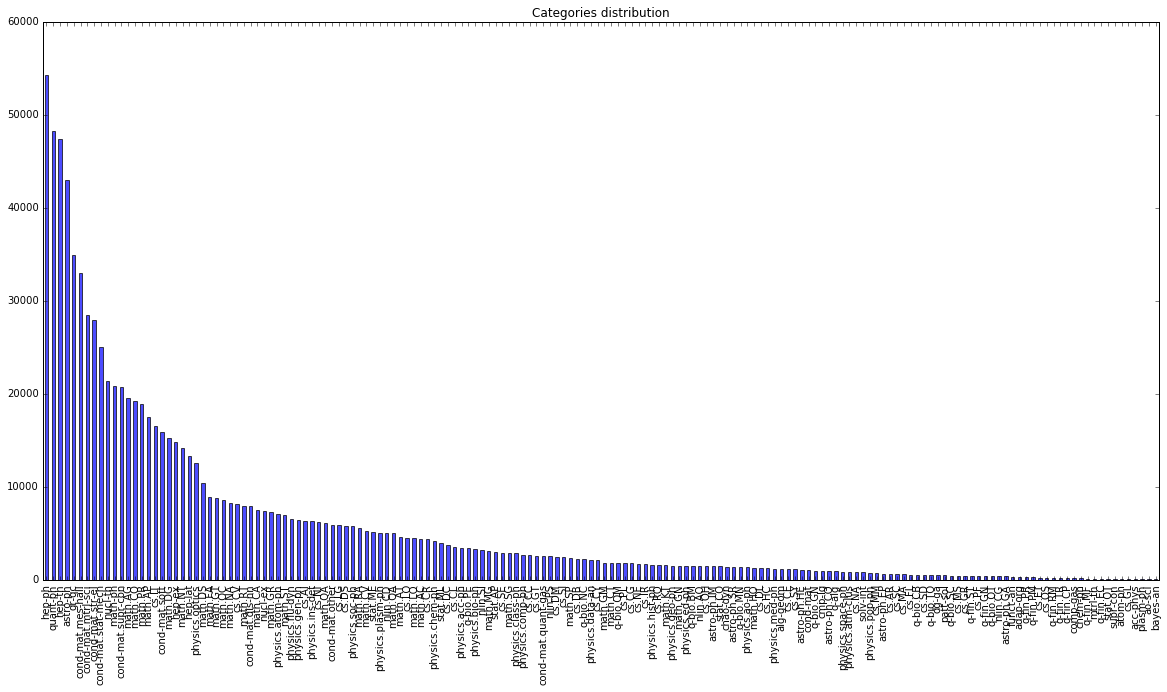

In [6]:
plt.figure(figsize=(20,10))
queries.primary_category.value_counts().plot(kind='bar', alpha=0.7)
plt.title("Categories distribution")

Распределение имеет длинный хвост -- это категории, которые покрывают небольшое количество статей. Выполним отсечение по медиане.

In [7]:
median = np.median(queries.primary_category.value_counts())
cat_count = dict(queries.primary_category.value_counts())
selected = []

for cat in cat_count.keys():
    if cat_count[cat] > median:
        selected.append(cat)
        
queries = queries[queries.primary_category.isin(selected)].reset_index(drop=True)

После того как были выброшены редкие категории, распределение приобрело следующий вид

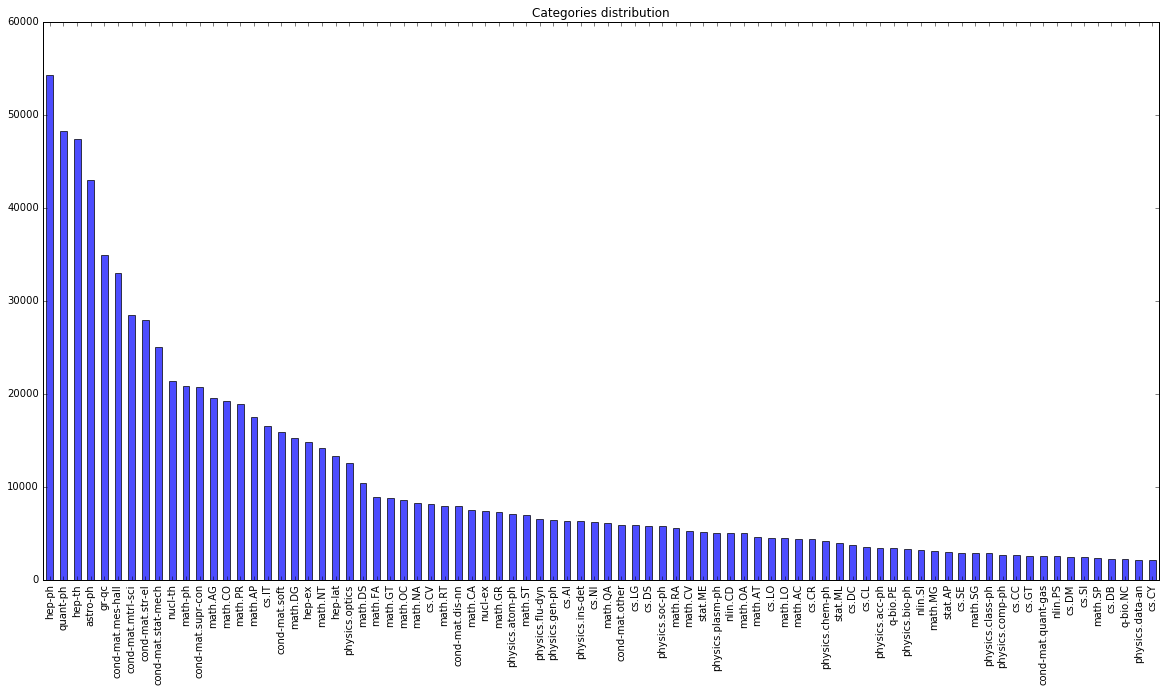

In [8]:
plt.figure(figsize=(20,10))
queries.primary_category.value_counts().plot(kind='bar', alpha=0.7)
plt.title("Categories distribution")

Некоторые id записаны некорректно и влючают ещё название категории, например, "hep-th/9201001". Отделим название категории от названия файла.

In [9]:
for i in range(len(queries)):
    if '/' in queries.iloc[i].id:
        name = queries.iloc[i].id.split('/')
        queries.iloc[i].id = name[1]

В списке category встречаются неизвестные названия категорий, которые сложно интерепретировать, например, 'I.2.6; K.3.2'. Удалим эти метки из category.

In [10]:
for i in range(len(queries)):
    cat_list = []
    cat = queries.category[i]
    if ',' not in cat:
        cat_list.append(cat[2:-2])
    for c in selected:
        if c in cat:
            cat_list.append(c)
    queries.category[i] = cat_list
    if i%10000 == 0:
        print("%d iterations" % i)

0 iterations
10000 iterations
20000 iterations
30000 iterations
40000 iterations
50000 iterations
60000 iterations
70000 iterations
80000 iterations
90000 iterations
100000 iterations
110000 iterations
120000 iterations
130000 iterations
140000 iterations
150000 iterations
160000 iterations
170000 iterations
180000 iterations
190000 iterations
200000 iterations
210000 iterations
220000 iterations
230000 iterations
240000 iterations
250000 iterations
260000 iterations
270000 iterations
280000 iterations
290000 iterations
300000 iterations
310000 iterations
320000 iterations
330000 iterations
340000 iterations
350000 iterations
360000 iterations
370000 iterations
380000 iterations
390000 iterations
400000 iterations
410000 iterations
420000 iterations
430000 iterations
440000 iterations
450000 iterations
460000 iterations
470000 iterations
480000 iterations
490000 iterations
500000 iterations
510000 iterations
520000 iterations
530000 iterations
540000 iterations
550000 iterations
560000

Посмотрим к какому количеству тем относятся документы.

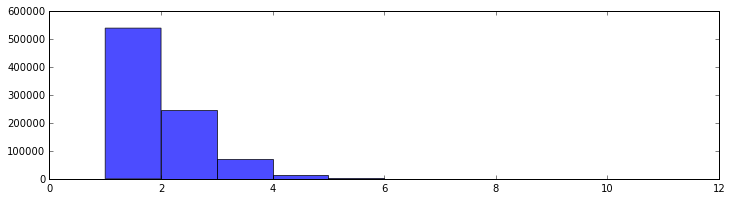

Максимальное число тем: 11
Среднее число тем: 1.506


In [25]:
freq = []
for i in list(queries.category):
    freq.append(len(i))

plt.figure(figsize=(12,3))
plt.hist(freq, alpha=0.7)
plt.show()

print("Максимальное число тем: %d" % max(freq))
print("Среднее число тем: %.3f" % np.mean(freq))

In [26]:
# Записываем результат

queries.to_csv(path + 'unique_queries.csv')

Файл доступен по [ссылке](https://drive.google.com/open?id=0B_NefGKQ1pCsZjhzUFNTdnJPZlE)

## Скачивание статей на диск

Около 60 тысяч документов было получено в результате прямого скачивания датасетов [отсюда](http://www.cs.cornell.edu/projects/kddcup/datasets.html)

In [ ]:
articles_path = 'C:\\Users\\user\\Downloads\\arxiv\\'   

'''for cat in categories:
    if not os.path.exists(articles_path + 'source\\' + cat):
        os.makedirs(articles_path + 'source\\' + cat)'''

Используем полученный ранее [файл](https://drive.google.com/open?id=0B_NefGKQ1pCsZjhzUFNTdnJPZlE) с метаданными статей для загрузки файлов на диск. Будем загружать только исходники, потому что  их проще обрабатывать (исходники записаны с формате tex, который имеет опреденную структуру и удобен для текстовой обработки).

In [ ]:
def get_articles(queries=queries, category='stat.AP', source=True, pdf=False, start=0):
    '''
    Description
    '''
    metadata = queries[queries.primary_category == category].reset_index(drop=True)
    n = len(metadata)
    arxiv_id = metadata.id
    pdfs = metadata.pdf_link
    sources = metadata.source_link
    categories = metadata.primary_category.unique()
    wait_time = 3
    
    for i in range(start, n):
        
        if i%50 == 0:
            time.sleep(wait_time) 
            print("Loaded %d files" % i)
        
        if source:
            filename = path + 'source\\' + arxiv_id[i]         
            
            if not os.path.isfile(filename):                              # Check exsisting   
                try:
                    urlretrieve(sources[i], filename)                     # Saving
                except urllib.request.HTTPError:
                    continue     
                    
        if pdf:
            filename = path + 'pdf\\' + arxiv_id[i] + '.pdf'
            if not os.path.isfile(filename): 
                urlretrieve(pdfs[i], filename)       

In [ ]:
%%time

for cat in categories:
    print("Loading category %s..." % subjects_dictionary[cat])
    %time get_articles(category=cat)
    print('\n')